## Planet: Understanding the Amazon Rain Forest from Space

Predict human footprint (agriculture, artisinal_mine, slash_burn) in the Amazon rainforest using satellite data. 
For more information: https://www.kaggle.com/c/planet-understanding-the-amazon-from-space

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

from planet import *

In [3]:
#bs=64; f_model = resnet34
path = "data/planet/"
#torch.cuda.set_device(1)

In [ ]:
n=len(list(open(f'{path}train_v2.csv')))-1; n

# Multi-label Classification

In [5]:
from fastai.plots import *

In [6]:
def get_1st(path): return glob(f'{path}/*.*')[0]

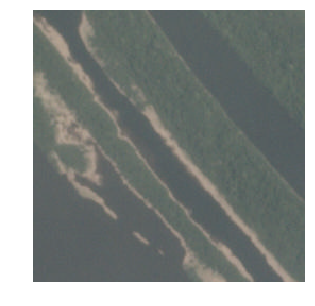

In [7]:
list_paths = [f"{path}train-jpg/train_20.jpg"]
plots_from_files(list_paths)

# Model for Planet dataset

In [8]:
from planet import f2

metrics = [f2]
f_model =resnext50

In [9]:
label_csv = f'{path}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [10]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(path, 'train-jpg', label_csv, tfms=tfms,
                                       suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [11]:
data = get_data(256)

In [ ]:
x, y = next(iter(data.val_dl))

In [ ]:
y

In [ ]:
list(zip(data.classes,y[0]))

In [ ]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4)

In [12]:
sz=64

In [13]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [14]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

In [ ]:
lrf = learn.lr_find()
learn.sched.plot()

In [21]:
lr=0.2

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [22]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save(f'{sz}')

In [ ]:
learn.load(f'{sz}')

In [ ]:
learn.sched.plot_loss()

In [24]:
sz=128

In [ ]:
learn.set_data(get_data(sz))
learn.freeze
learn.bn_freeze(True)

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
#learn.save(f'{sz}')

In [16]:
f'{sz}'

'128'

In [25]:
learn.load(f'{sz}')

In [26]:
sz=256

In [27]:
learn.set_data(get_data(sz))
learn.freeze
learn.bn_freeze(True)

In [28]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.08368  0.08887  0.92497]                           
[ 1.       0.08094  0.08843  0.92569]                         
[ 2.       0.08233  0.08814  0.9252 ]                         
[ 3.       0.08069  0.08822  0.92528]                         
[ 4.       0.07995  0.08822  0.9256 ]                         
[ 5.       0.07949  0.08795  0.92581]                         
[ 6.       0.07854  0.08752  0.92624]                         



In [29]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.07869  0.08498  0.92979]                         
[ 1.       0.08501  0.08741  0.92899]                         
[ 2.       0.07466  0.0842   0.9293 ]                         
[ 3.       0.08702  0.08727  0.92594]                         
[ 4.       0.08179  0.08691  0.92565]                         
[ 5.       0.07377  0.08349  0.93083]                         
[ 6.       0.07281  0.08452  0.92944]                         



In [30]:
f'{sz}'

'256'

In [31]:
learn.save(f'{sz}')

In [32]:
log_preds,y = learn.TTA()

In [33]:
preds = np.mean(np.exp(log_preds),0)

In [34]:
f2(preds,y)

0.48394347741367771

In [37]:
import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (2048, rlimit[1]))

In [38]:
prob_preds, y= learn.TTA(is_test=True)

In [41]:
test_fnames = data.test_ds.fnames

In [42]:
for i in range(len(test_fnames)):
    test_fnames[i] = test_fnames[i].split("/")[1].split(".")[0]

In [45]:
classes = np.array(data.classes, dtype=str)
res = [" ".join(classes[np.where(pp > 0.2)]) for pp in prob_preds[0]]

In [47]:
submission.columns = ["tags"]

In [48]:
submission.insert(0, 'image_name', test_fnames)

In [ ]:
submission.to_csv(path+"Planet_submission_01.csv", index=False)